In [1]:
include("../src/HPFEM.jl")

HPFEM

In [53]:
TF = BigFloat
nel = 20
nnodes = nel + 1
idir = [1,nnodes]
M = 60
Q = M+2
b = HPFEM.Lagrange1d(M, TF)
quad = HPFEM.QuadType(Q, HPFEM.GLJ, TF)
bas = HPFEM.Basis1d(b,quad, TF)
#bas = HPFEM.SEM1d(M)
#bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [54]:
typeof(bas)

HPFEM.Basis1d{BigFloat,HPFEM.Lagrange1d{BigFloat}}

In [55]:
k = 2
uexact(x) = sin(2π*k*x)
rhsfun(x) = sin(2π*k*x) * (1 + (2π*k)^2)


rhsfun (generic function with 1 method)

In [56]:
a = 1.7
b = 6.3
nodes = [TF(x) for x in linspace(a, b, nnodes)];

In [57]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [58]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix1d, TF);

In [59]:
for e = 1:nel
    Ae = zeros(TF, M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [60]:
Fe = zeros(TF, HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
bnd = HPFEM.bndidx(lmap)
Fe[bnd[1],1] = uexact(a);
Fe[bnd[2],nel] = uexact(b);

In [61]:
HPFEM.solve!(solver, Fe);

In [62]:
nξ = 101
ξ = collect(linspace(TF(-1),TF(1),nξ));
ϕ = zeros(TF, nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

In [77]:
typeof(Ue)

Array{BigFloat,2}

BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat
BigFloat


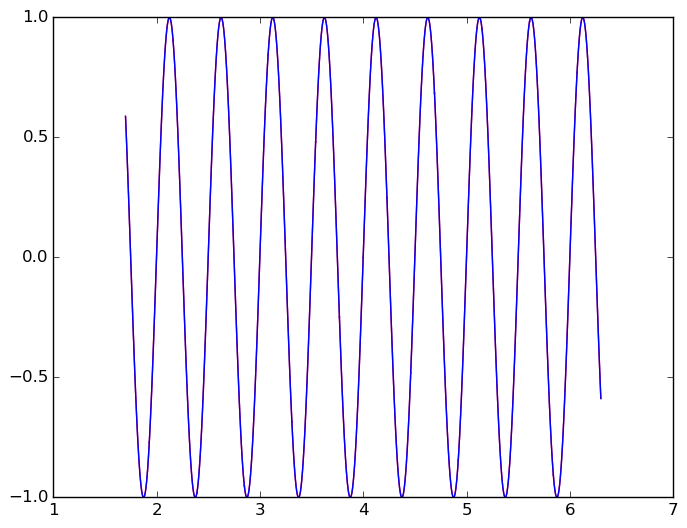

1.224646799147353177226065932275001058209749445923078164062861980294536250318213e-16

In [78]:
using PyPlot
maxerr = zero(TF)
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    println(typeof(maxerr))
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr
BigFloat(π) - 1.0π